**Лабораторная работа № 3.**

**Многослойные сети. Алгоритм обратного распространения ошибки**

Ивченко Анна группа М8О-408Б-20

вариант 9

Целью работы является исследование свойств многослойной нейронной сети прямого распространения и алгоритмов ее обучения, применение сети в задачах классификации и аппроксимации функции.

Эллипс: a = 0.2, b = 0.2, α = 0, x0 = −0.2, y0 = 0

Эллипс: a = 0.7, b = 0.5, α = −π/3, x0 = 0, y0 = 0

Эллипс: a = 1, b = 1, α = 0, x0 = 0, y0 = 0

In [1]:
import numpy as np

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import matplotlib.pyplot as plt

# Задание 1

Попробуем применить многослойный перцептрон для классификации линейно неразделимых множеств

Сгенерируем датасет. Датасет будет состоять из точек, принадлежащим границам трех эллипсов

In [3]:
ellipse0 = dict(
    a = 0.2,
    b = 0.2,
    alpha = 0,
    x0 = -0.2,
    y0 = 0,
    label = 0,
)

ellipse1 = dict(
    a = 0.7,
    b = 0.5,
    alpha = -np.pi / 3,
    x0 = 0,
    y0 = 0,
    label = 1,
)

ellipse2 = dict(
    a = 1,
    b = 1,
    alpha = 0,
    x0 = 0,
    y0 = 0,
    label = 2,
)

In [4]:
def gen_dataset(ellipses):
    t = np.linspace(0, 2 * np.pi, int(2 * np.pi / 0.025))

    points = np.array([
        [
            ellipses[i]['a'] * np.cos(t) * np.cos(ellipses[i]['alpha']) \
            - ellipses[i]['b'] * np.sin(t) * np.sin(ellipses[i]['alpha']) \
            + ellipses[i]['x0'],

            ellipses[i]['a'] * np.cos(t) * np.sin(ellipses[i]['alpha']) \
            + ellipses[i]['b'] * np.sin(t) * np.cos(ellipses[i]['alpha']) \
            + ellipses[i]['y0'],

            np.tile(ellipses[i]['label'], len(t)),

         ] for i in range(len(ellipses))])

    np.random.seed(0xDEAD)

    el_0 = points[0, :, np.random.choice(len(t), 60, replace=False)]
    el_1 = points[1, :, np.random.choice(len(t), 100, replace=False)]
    el_2 = points[2, :, np.random.choice(len(t), 120, replace=False)]

    data = np.vstack((el_0, el_1, el_2))
    np.random.shuffle(data)

    return data

В результате выполнения этой функции мы получаем массив данных, содержащий случайные точки, сгенерированные на заданных эллипсах. Каждая точка представлена в виде трех чисел (x, y, label), где x и y - координаты точки на плоскости, а label - метка эллипса, к которому принадлежит точка.

In [5]:
data1 = gen_dataset([ellipse0, ellipse1, ellipse2])

In [6]:
data1.shape

(280, 3)

Посмотрим на получившийся датасет

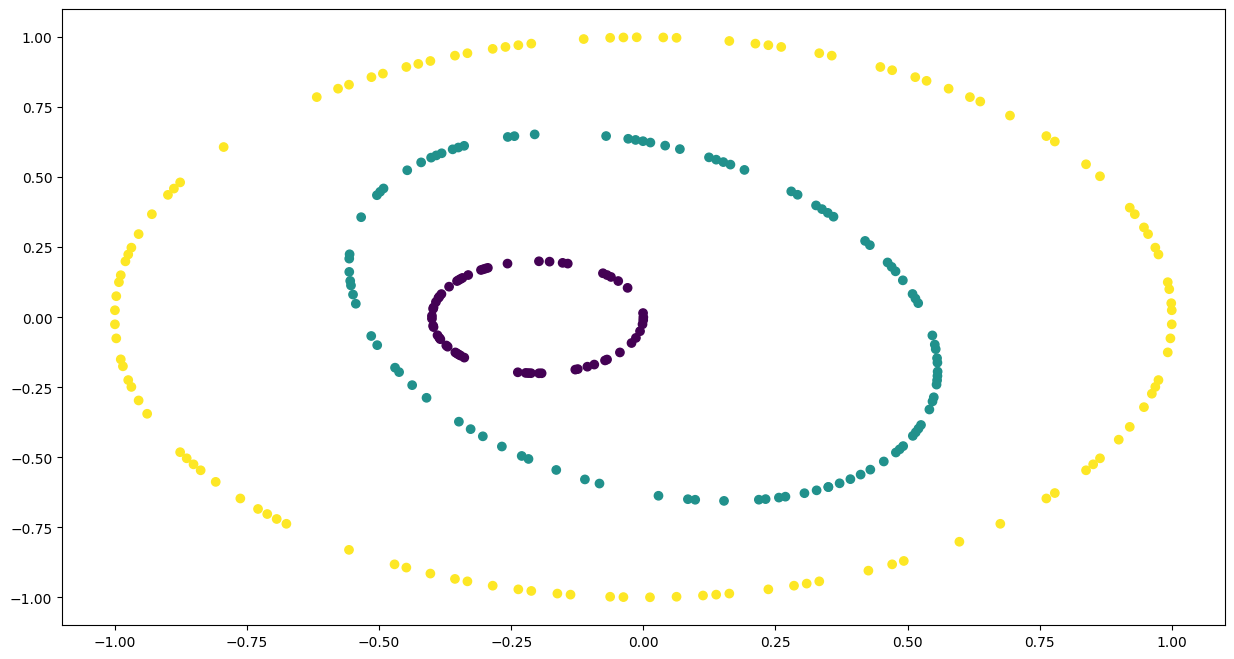

In [7]:
plt.figure(figsize=(15, 8))
plt.scatter(data1[:, 0], data1[:, 1], c=data1[:, 2])
plt.show()

Поделим данные на трейн, тест и валидацию

In [8]:
train, val, test = np.split(data1, [int(.7*len(data1)), int(.9*len(data1))])

In [9]:
train.shape, val.shape, test.shape

((196, 3), (56, 3), (28, 3))

Разделим данные на тренировочный, тестовый и валидационный наборы

In [10]:
X_train = train[:, :2]
y_train = train[:, 2]

X_test = test[:, :2]
y_test = test[:, 2]

X_val = val[:, :2]
y_val = val[:, 2]

Будем использовать двухслойный перцептрон. В скрытом слое по заданию будет 20 нейронов. В качестве функции активации будем использовать танх, алгоритм обучения - RMSProp

In [11]:
model1 = keras.Sequential([
    keras.layers.Dense(20, activation='tanh'),
    keras.layers.Dense(3, activation='softmax'),
])

In [12]:
model1.compile(
    loss='sparse_categorical_crossentropy',
    optimizer='Adam',
    metrics='accuracy'
)

Выполним обучение модели на тренировочных данных

In [13]:
train_info1 = model1.fit(
    X_train,
    y_train,
    batch_size=1,
    epochs=500,
    validation_data=(X_val, y_val),
    shuffle=True,
    verbose=0
)

Посмотрим на графики.
Отобразим графики для метрик потерь и точности модели во время обучения

In [14]:
def plot_metrics(train_info):
    plt.figure(figsize=(15, 8))

    plt.subplot(1, 2, 1)
    loss_history = train_info.history['loss']
    val_loss_history = train_info.history['val_loss']
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.plot(range(1, len(loss_history) + 1), loss_history, label='train')
    plt.plot(range(1, len(loss_history) + 1), val_loss_history, label='val')
    plt.grid()
    plt.legend()
    plt.title('Loss')

    plt.subplot(1, 2, 2)
    acc_history = train_info.history['accuracy']
    val_acc_history = train_info.history['val_accuracy']
    plt.xlabel('epoch')
    plt.ylabel('acc')
    plt.plot(range(1, len(acc_history) + 1), acc_history, label='train')
    plt.plot(range(1, len(val_acc_history) + 1), val_acc_history, label='val')
    plt.grid()
    plt.legend()
    plt.title('Accuracy')

    plt.show()

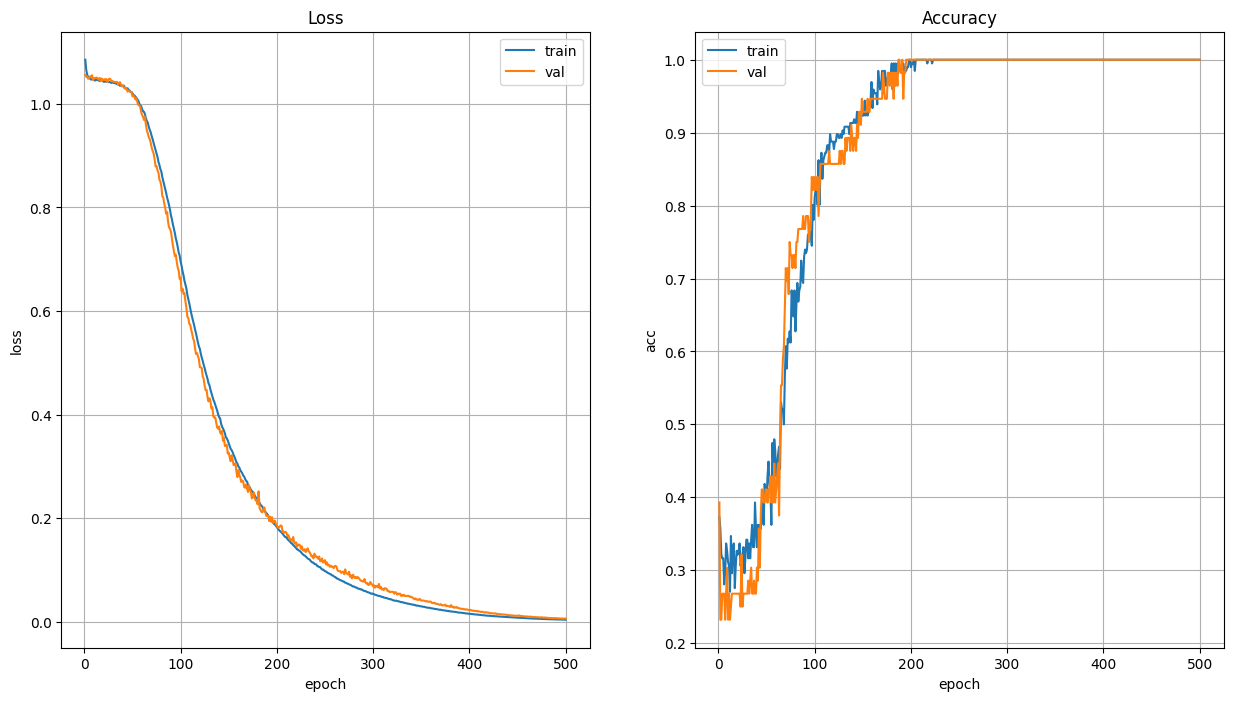

In [15]:
plot_metrics(train_info1)

In [16]:
print("Val accuracy =", train_info1.history['val_accuracy'][-1])

Val accuracy = 1.0


Получили очень идеальную точность на валидации.

Проверим, что происходит с тестовой выборкой.

In [17]:
np.argmax(model1.predict(X_test, verbose=0), axis=1).shape

(28,)

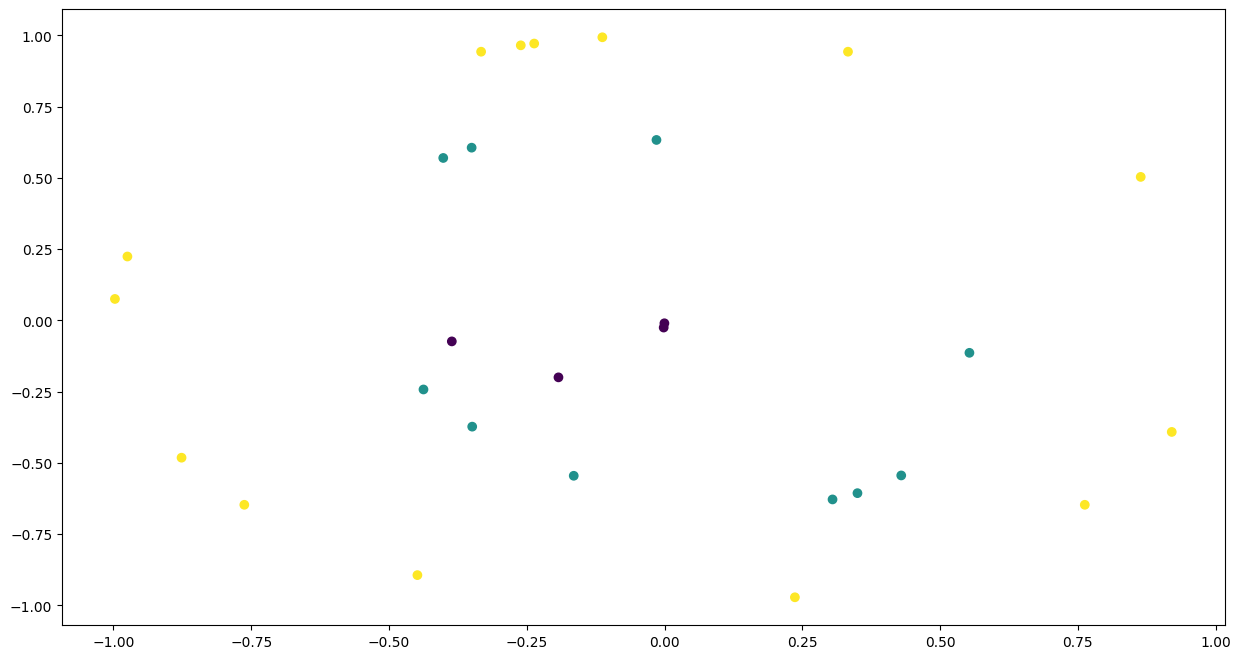

In [18]:
plt.figure(figsize=(15, 8))
plt.scatter(X_test[:, 0], X_test[:, 1], c=np.argmax(model1.predict(X_test, verbose=0), axis=1))
plt.show()

In [19]:
print("Test accuracy =", (np.argmax(model1.predict(X_test, verbose=0), axis=1) == y_test).mean())

Test accuracy = 1.0


Видим, что все точки на эллипсах классифицированы верно

Построим на классификацию точек во всей области

In [20]:
h = 0.025

grid = [model1.predict(np.array([[i, j]]), verbose=0).round(1)
        for i in np.arange(-1.2, 1.2 + h, h)
        for j in np.arange(-1.2, 1.2 + h, h)]

In [21]:
x_vals = np.arange(-1.2, 1.2 + h, h)
y_vals = np.arange(-1.2, 1.2 + h, h)

xx, yy = np.meshgrid(x_vals, y_vals)

In [22]:
colors = np.array(grid).reshape((len(grid), 3))
colors.shape

(9409, 3)

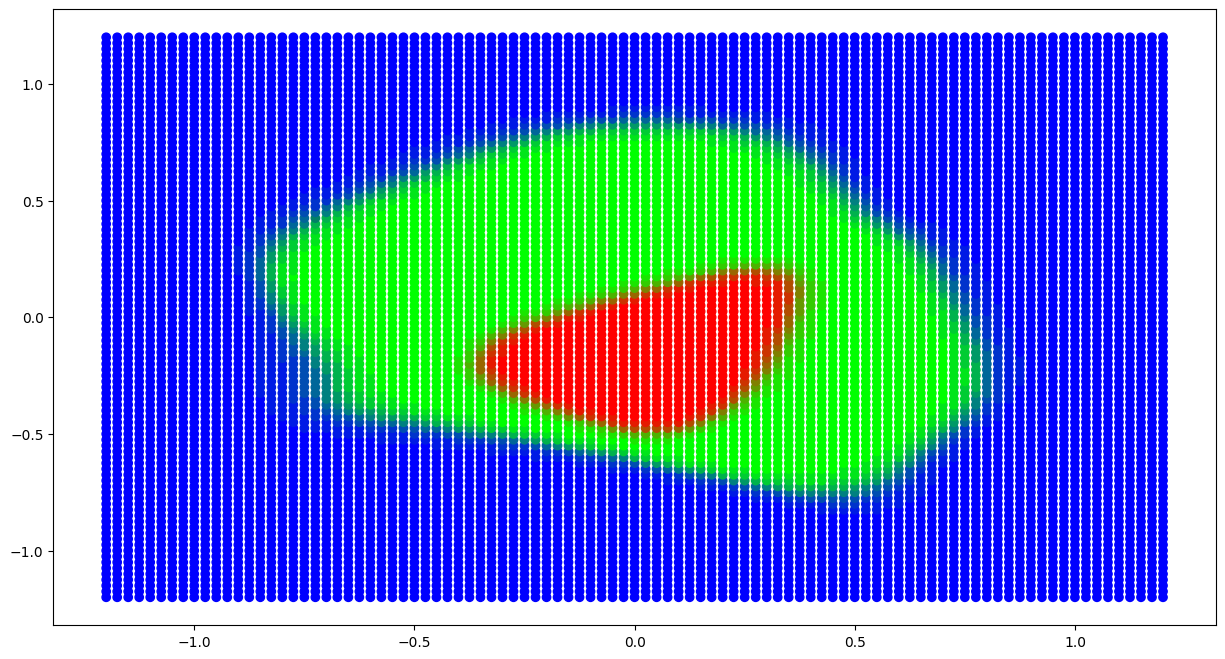

In [23]:
plt.figure(figsize=(15, 8))

plt.scatter(xx, yy, c=colors)

plt.show()

Как мы видим, картинка, похожая на изначальный датасет с эллипсами

## Задание 2
Пробуем аппроксимировать функцию многослойной сетью с помощью методов первого порядка

In [24]:
def fun(t):
    return np.sin(t**2 -2*t + 5)

range_t = (0, 5)
h = 0.025

Подготовим датасет:

In [25]:
t = np.linspace(range_t[0], range_t[1], int((range_t[1] - range_t[0]) / h))
x = fun(t)

Поделим на трейн и вал

In [26]:
train_len = int(t.shape[0] * 0.9)

t_train = t[:train_len]
t_val = t[train_len:]

x_train = x[:train_len]
x_val = x[train_len:]

In [27]:
t_train = np.expand_dims(t_train, 1)
t_val = np.expand_dims(t_val, 1)

In [28]:
t_train.shape, t_val.shape

((180, 1), (20, 1))

Обучим модель. В качестве алгоритма обучения возьмем Adam (метод оптимизации 1 порядка)

In [29]:
model2 = keras.Sequential([
    keras.layers.Dense(64, activation='tanh'),
    keras.layers.Dense(32, activation='tanh'),
    keras.layers.Dense(1),
])

In [30]:
model2.compile(
    loss='mse',
    optimizer='Adam',
    metrics=tf.keras.metrics.RootMeanSquaredError(),
)

In [31]:
train_info2 = model2.fit(
    t_train,
    x_train,
    batch_size=4,
    epochs=2000,
    validation_data=(t_val, x_val),
    verbose=0
)


Посмотрим на лосс и метрики

In [32]:
def plot_metrics2(train_info):
    plt.figure(figsize=(15, 8))

    plt.subplot(1, 2, 1)
    loss_history = train_info.history['loss']
    val_loss_history = train_info.history['val_loss']
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.plot(range(1, len(loss_history) + 1), loss_history, label='train')
    plt.plot(range(1, len(loss_history) + 1), val_loss_history, label='val')
    plt.grid()
    plt.legend()
    plt.title('Loss')

    plt.subplot(1, 2, 2)
    acc_history = train_info.history['root_mean_squared_error']
    val_acc_history = train_info.history['val_root_mean_squared_error']
    plt.xlabel('epoch')
    plt.ylabel('RMSE')
    plt.plot(range(1, len(acc_history) + 1), acc_history, label='train')
    plt.plot(range(1, len(val_acc_history) + 1), val_acc_history, label='val')
    plt.grid()
    plt.legend()
    plt.title('RMSE')

    plt.show()

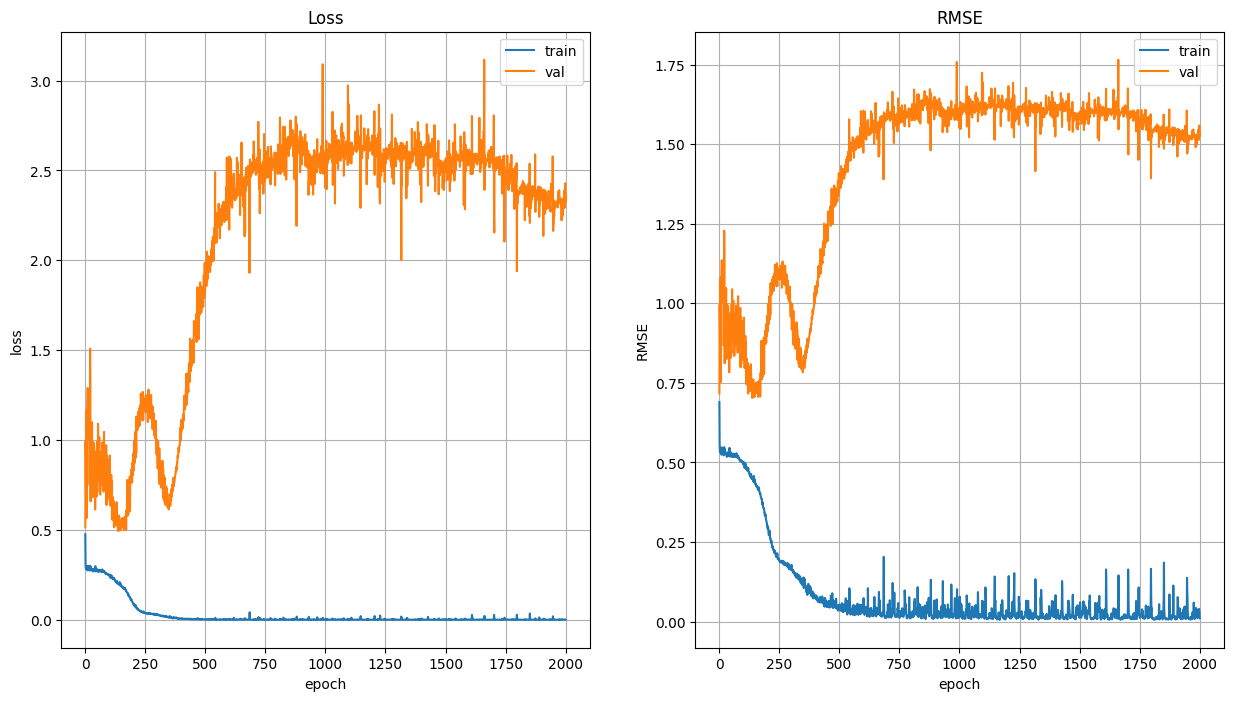

In [33]:
plot_metrics2(train_info2)

In [ ]:
print("Val RMSE =", train_info2.history['val_root_mean_squared_error'][-1])

Посмотрим на результаты на трейне

In [34]:
def plot_results(model, t, fun):
    plt.figure(figsize=(15, 8))

    plt.plot(t, fun(t), label='true')
    plt.plot(t, model.predict(t), label='pred')

    plt.grid()
    plt.legend()
    plt.show()

6/6 [==============================] - 0s 3ms/step


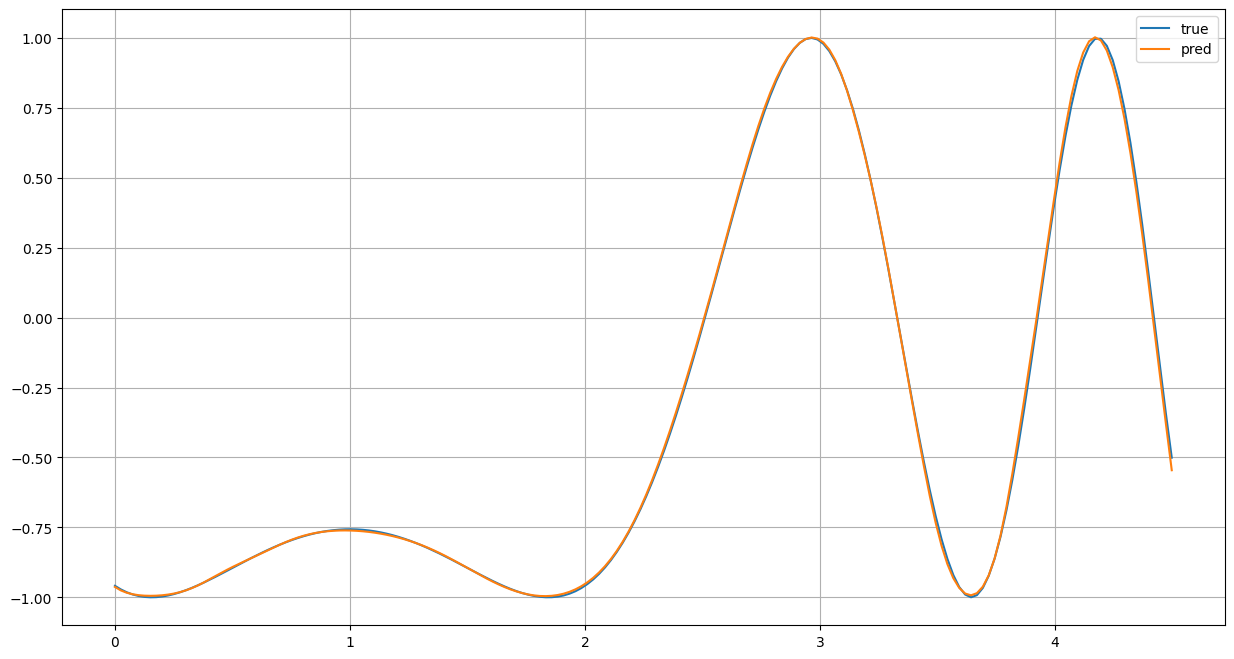

In [35]:
plot_results(model2, t_train, fun)

И на вале

1/1 [==============================] - 0s 37ms/step


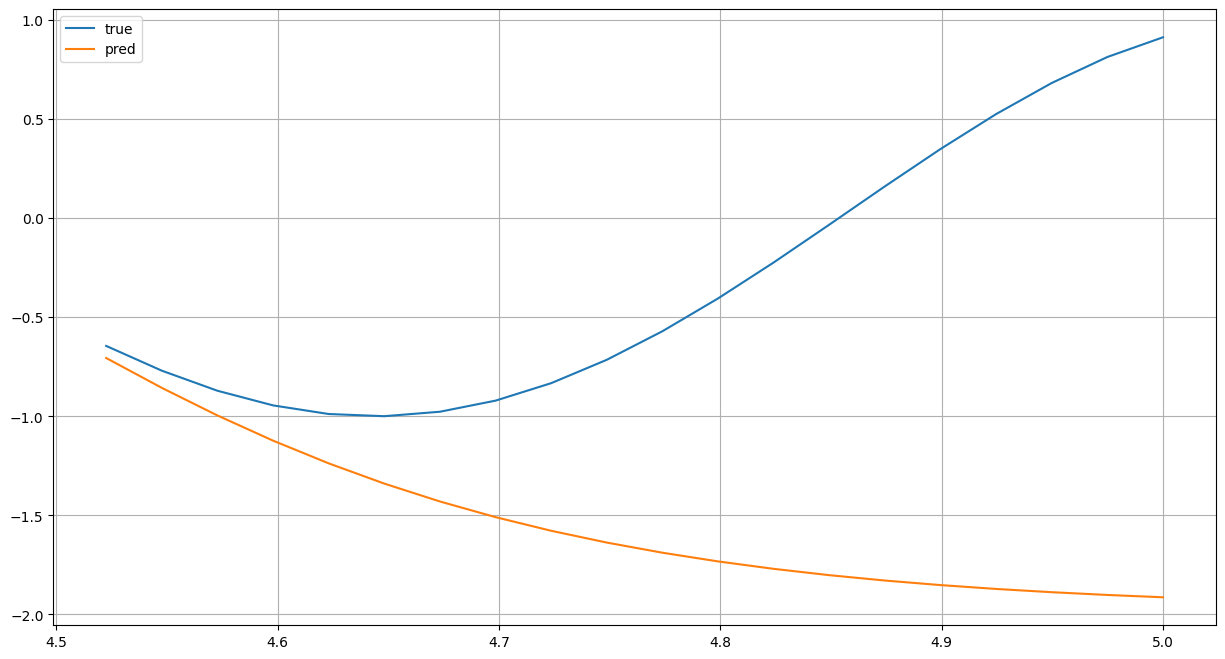

In [36]:
plot_results(model2, t_val, fun)

И как мы видим, с правой частью кривой (и с валидацией в том числе) модель справляется не очень хорошо

# Вывод
В данной работе я практиковалась в использовании сложных нейросетей. Они позволили мне успешно решить задачу классификации на 3 класса, которые нельзя было разделить прямой линией. Я также попыталась аппроксимировать нелинейную функцию.

Для аппроксимации функции я использовала два метода обучения - Адам (метод первого порядка) и метод Ньютона (метод второго порядка). Оказалось, что метод второго порядка работал медленнее и менее точно.

Однако не получилось достичь хорошего результата. Ни одна модель не смогла правильно аппроксимировать функцию на валидационной выборке. Все модели продолжали строить прямые, вместо того чтобы изгибаться.
